In [1]:
!pip install Unidecode

     |████████████████████████████████| 245kB 5.5MB/s 


In [2]:
import ee
import time
import sys
from unidecode import unidecode
import argparse
import os.path
import matplotlib.pyplot as plt
import numpy as np
import cv2
from random import random
try:
    from google.colab.patches import cv2_imshow
except:
    from cv2 import imshow as cv2_imshow


In [3]:
#initialize google earth engine
try:
  ee.Initialize()
except:
  ee.Authenticate()
  ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=0Xy9as984p7LU4ZNOYv9ycZK2qtCmAd452yq64276cQ&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g6S3cx5Q_TH-Ilr_gnh6sqO0-CtFYduh_RnMq37b8yQhwSt-CobRgc

Successfully saved authorization token.


# Global variables

In [30]:
# name of GEE collections:
IMG_COLLECTIONS = ['MODIS/006/MOD09A1', 'MODIS/006/MYD11A2', 'MODIS/006/MCD12Q1', 'LANDSAT/LC08/C01/T1_TOA', 'MODIS/006/MOD13Q1', 'COPERNICUS/Landcover/100m/Proba-V-C3/Global']
# Images codes -- description
IMG_COLLECTION_CODES = ['reflectance', 'Temperature', 'cover', 'rgb', 'NDVI', 'COPERNICUS_Landcover']

# Data range to be downloaded for each collection
# MAKE SURE the dates are in the date range of the GEE layer (check on GEE website)
IMG_START_DATES = ['2018-01-01', '2017-01-01', '2017-01-01', '2017-01-01', '2017-01-01', '2018-01-01']
IMG_END_DATES = ['2019-01-01', '2018-01-01', '2018-01-01', '2018-01-01', '2018-01-01', '2019-01-01']

# Bands that will be selected in each collection
IMG_COLLECTION_BANDS = [['sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b04', 'sur_refl_b05', 'sur_refl_b06', 'sur_refl_b07'], 
                        ['LST_Day_1km', 'LST_Night_1km'], ['LC_Type1'], ['B4', 'B3', 'B2'], ['NDVI'], ['discrete_classification']]


# Ranges for plotting images (debug mode = True)                      
IMG_COLLECTION_MIN = [-100.0, 14000.0, 17.0, 0.0, 0.0, 0.0]
IMG_COLLECTION_MAX = [3000.0, 16000.0, 1.0, 0.4, 8000.0, 20.0]
CLEAN_NAME = lambda r, l: unidecode(r.get('properties').get(l)).lower().translate("'()/&-").strip()

# Functions

In [5]:
def export_to_cloud(img, fname, folder, expregion, eeuser=None, scale=10):
  task = ee.batch.Export.image.toDrive(**{
      'image': img.clip(expregion),
      'description':fname, 
      'folder':folder, 
      'fileNamePrefix':fname, 
      'dimensions':None, 
      'region':expregion.geometry().bounds().getInfo()['coordinates'],
      'scale':scale, 
      'crs':'EPSG:4326', 
      'crsTransform':None, 
      'maxPixels':1e13
  })
  task.start()
  while task.status()['state'] == 'RUNNING':
    print('Running...')
    time.sleep(20)
  print('Done.'.format(task.status()))
  time.sleep(10)

In [6]:
def appendBand(current, previous):
    # Rename the band
    previous=ee.Image(previous)
    current = current.select(IMG_COLLECTION_BANDS[img_collection_index])
    # Append it to the result (Note: only return current item on first element/iteration)
    accum = ee.Algorithms.If(ee.Algorithms.IsEqual(previous,None), current, previous.addBands(ee.Image(current)))
    # Return the accumulation
    return accum


In [7]:
def export_images_collection(ftr_collection, boundary_filter, collection_name, folder_name_drive, only_download_first_image=True, debug=False, scale=100):
    img_collection_index = IMG_COLLECTION_CODES.index(collection_name)
    image_collection = IMG_COLLECTIONS[img_collection_index]
    start_date = IMG_START_DATES[img_collection_index]
    end_date = IMG_END_DATES[img_collection_index]
    county_region = ee.FeatureCollection(ftr_collection)

    feature_list = county_region.toList(1e5)
    feature_list_computed = feature_list.getInfo()

    # Get ImageCollection
    imgcoll = ee.ImageCollection(image_collection) \
      .filterDate(start_date,end_date)\
      # .filterBounds(ee.Geometry.Rectangle(boundary_filter));  #focus on a rectangle around Senegal
        
    # appends timestamps into bands
    img=imgcoll.iterate(appendBand)
    img=ee.Image(img)
    totalImages = imgcoll.size().getInfo()
    print("Total count of images in the collection:{} for the date range: {} - {}".format(totalImages, start_date, end_date))

    for idx, region in enumerate(feature_list_computed):
      subunit_key = ftr_key_fn(region)

      if debug:
        for i in range(1): #ONLY PLOT 2 first images (Timestamps)
          first_image = ee.Image(imgcoll.toList(imgcoll.size()).get(i))
          bands = IMG_COLLECTION_BANDS[img_collection_index][0] #visualize only first band
          plotROI(first_image, ee.Feature(region),debug=debug, 
                  bands=bands, max=IMG_COLLECTION_MAX[img_collection_index])
      file_name = country + '_' + collection_name + '_' + subunit_key + "_" + start_date + "_" + end_date
      print(file_name)
      print(idx)
      folder_name = os.path.join(folder_name_drive, collection_name)
      export_to_cloud(img, file_name, folder_name, ee.Feature(region), scale=scale)
      if only_download_first_image:
        break #only first image 

In [8]:
# Visualize ROI (Region of interest) -- Works for Landsat; Issue with Sentinal

def plotROI(image,roi, debug = False, bands = ['B4', 'B3', 'B2'], max = 0.5):
  
  date = image.date().format('YYYY-MM-dd').getInfo()
  if debug: print('Timestamp: ', date);
  url = image.getThumbURL({
  'bands': bands,
  'min':0,
  'max':max,
  'region': roi
  })
  fname = "RGB_"+str(date)+str(random()).split('.')[1]+".png"

  status = os.system(f"""wget -O "{fname}" -c --read-timeout=5 --tries=0 "{url}" """)

  if (not status):
    if debug: 
      print("File name:", fname)
      img = cv2.imread(fname)
      cv2_imshow(img)
  return date, fname

# GEE 

In [9]:
country = 'senegal'
folder_name_drive = "Senegal_modis"

# rough rectangle around senegal to help GEE focus on this area
boundary_filter = [-17.891849582500733,12.010217171292826, -10.83862692625073,16.776053324382982]

# using shapefile from https://gadm.org/ level 1 is regions 
ftr_collection = 'users/margauxmasson21/SEN1'

# using shapefile from https://gadm.org/ level 2 is departments
# ftr_collection = 'users/margauxmasson21/SEN2'

ftr_key_fn = lambda region: CLEAN_NAME(region, 'NAME_0') + "-" +  CLEAN_NAME(region,'NAME_1') # SN: "<zone name>-<state name>"]

##### IF YOU WANT TO DOWNLOAD DAT FOR ANOTHER COUNTRY CHANGE THE PARAMETERS ABOVE ########
ftr_filter_fn = lambda region: True


# Export images to Drive 

Sat images: MOD09A1.006 Terra Surface Reflectance 8-Day Global 500m

Total count of images in the collection:46 for the date range: 2018-01-01 - 2019-01-01
Timestamp:  2018-01-01
File name: RGB_2018-01-014946240498565515.png


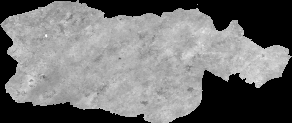

senegal_reflectance_senegal-diourbel_2018-01-01_2019-01-01
0
Done.
Timestamp:  2018-01-01
File name: RGB_2018-01-016840794265846707.png


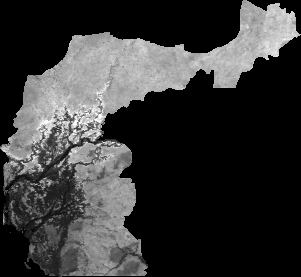

senegal_reflectance_senegal-fatick_2018-01-01_2019-01-01
1
Done.
Timestamp:  2018-01-01
File name: RGB_2018-01-0115509659417806354.png


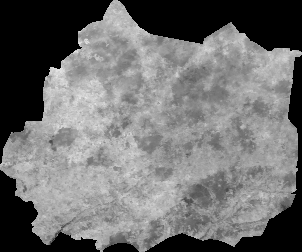

senegal_reflectance_senegal-kaffrine_2018-01-01_2019-01-01
2
Done.
Timestamp:  2018-01-01
File name: RGB_2018-01-019266736511617208.png


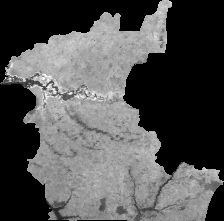

senegal_reflectance_senegal-kaolack_2018-01-01_2019-01-01
3
Done.
Timestamp:  2018-01-01
File name: RGB_2018-01-018703424754704151.png


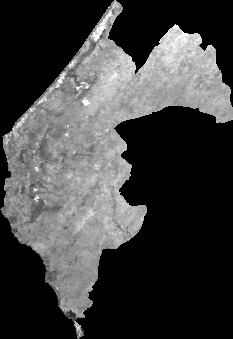

senegal_reflectance_senegal-thies_2018-01-01_2019-01-01
4
Done.
Timestamp:  2018-01-01
File name: RGB_2018-01-019098894490154537.png


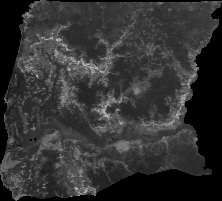

senegal_reflectance_senegal-ziguinchor_2018-01-01_2019-01-01
5
Done.
Timestamp:  2018-01-01
File name: RGB_2018-01-01823119906117081.png


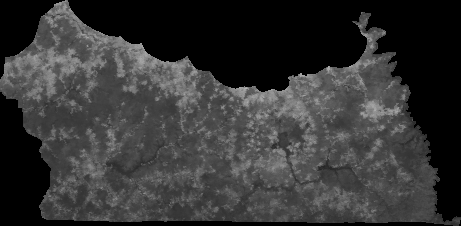

senegal_reflectance_senegal-kolda_2018-01-01_2019-01-01
6
Done.
Timestamp:  2018-01-01
File name: RGB_2018-01-018712497896223381.png


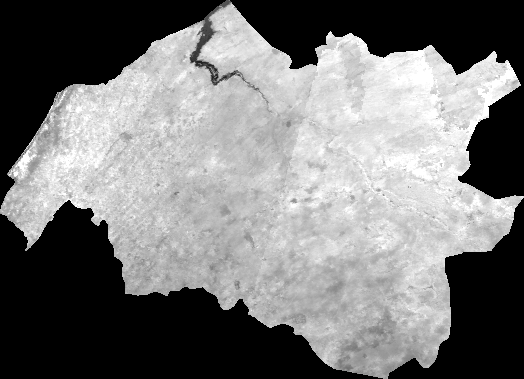

senegal_reflectance_senegal-louga_2018-01-01_2019-01-01
7
Done.
Timestamp:  2018-01-01
File name: RGB_2018-01-0115299452559039728.png


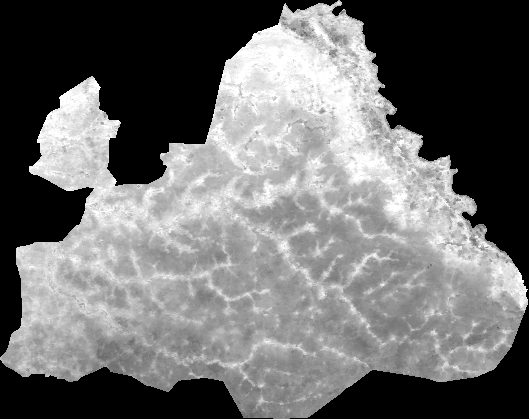

senegal_reflectance_senegal-matam_2018-01-01_2019-01-01
8
Done.
Timestamp:  2018-01-01
File name: RGB_2018-01-017954995404246262.png


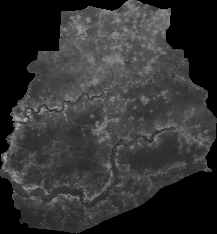

senegal_reflectance_senegal-sedhiou_2018-01-01_2019-01-01
9
Done.
Timestamp:  2018-01-01
File name: RGB_2018-01-019240216448495657.png


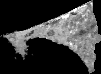

senegal_reflectance_senegal-dakar_2018-01-01_2019-01-01
10
Done.
Timestamp:  2018-01-01
File name: RGB_2018-01-0120908985770823896.png


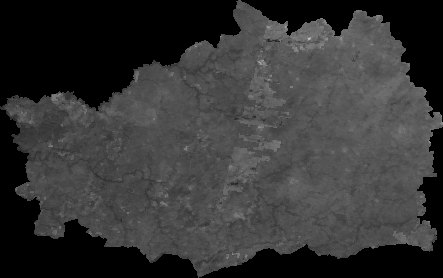

senegal_reflectance_senegal-kedougou_2018-01-01_2019-01-01
11
Done.
Timestamp:  2018-01-01
File name: RGB_2018-01-017604699822508676.png


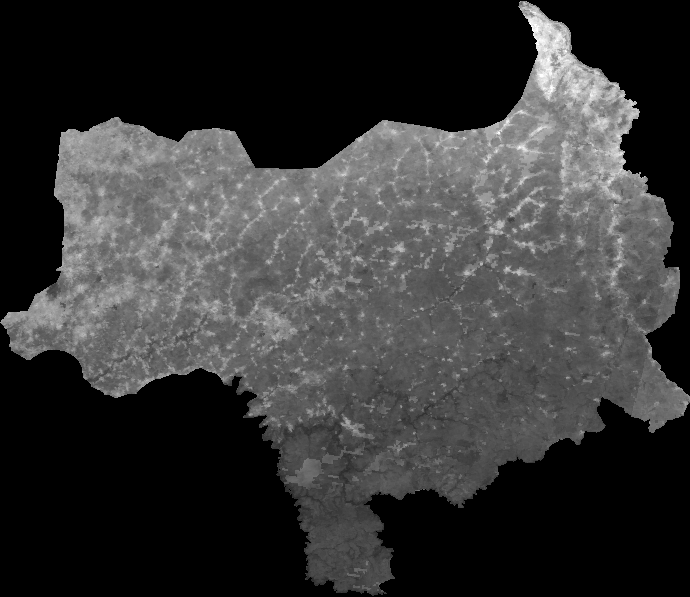

senegal_reflectance_senegal-tambacounda_2018-01-01_2019-01-01
12
Done.
Timestamp:  2018-01-01
File name: RGB_2018-01-018246678461044832.png


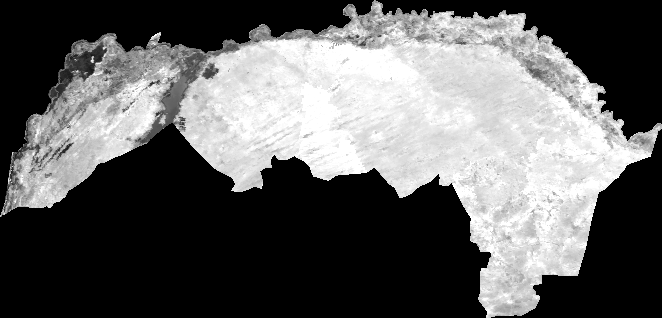

senegal_reflectance_senegal-saint-louis_2018-01-01_2019-01-01
13
Done.


In [31]:
# !it takes some time to download all the images on the Drive and the storage will reach a limit pretty fast, do not run these function all at once 
# To check the progress you can see the "tasks" section in https://code.earthengine.google.com/
collection_name = 'reflectance'
img_collection_index = IMG_COLLECTION_CODES.index(collection_name)
export_images_collection(ftr_collection, boundary_filter, collection_name, folder_name_drive, only_download_first_image=False, debug=True, scale=150)

D13Q1.006 Terra Vegetation Indices 16-Day Global 250m

In [ ]:
# !it takes some time to download all the images on the Drive and the storage will reach a limit pretty fast, do not run these function all at once 
# To check the progress you can see the "tasks" section in https://code.earthengine.google.com/
collection_name = 'NDVI'
img_collection_index = IMG_COLLECTION_CODES.index(collection_name)
export_images_collection(ftr_collection, boundary_filter, collection_name, folder_name_drive, only_download_first_image=False, debug=True, scale=100)

Temperature: MYD11A2.006 Aqua Land Surface Temperature and Emissivity 8-Day Global 1km

In [ ]:
collection_name = 'Temperature'
img_collection_index = IMG_COLLECTION_CODES.index(collection_name)
export_images_collection(ftr_collection, boundary_filter, collection_name, folder_name_drive, only_download_first_image=False, debug=True, scale=100)

Land cover: MCD12Q1.006 MODIS Land Cover Type Yearly Global 500m

In [ ]:
collection_name = 'cover'
img_collection_index = IMG_COLLECTION_CODES.index(collection_name)
export_images_collection(ftr_collection, boundary_filter, collection_name, folder_name_drive, only_download_first_image=False, debug=True)

RGB: USGS Landsat 8 Collection 1 Tier 1 and Real-Time data Raw Scenes


In [ ]:
collection_name = 'rgb'
img_collection_index = IMG_COLLECTION_CODES.index(collection_name)
export_images_collection(ftr_collection, boundary_filter, collection_name, folder_name_drive, only_download_first_image=True, debug=True)
# why is this rectangle different from with other databases?

In [ ]:
# !it takes some time to download all the images on the Drive and the storage will reach a limit pretty fast, do not run these function all at once 
# To check the progress you can see the "tasks" section in https://code.earthengine.google.com/
collection_name = 'COPERNICUS_Landcover'
img_collection_index = IMG_COLLECTION_CODES.index(collection_name)
export_images_collection(ftr_collection, boundary_filter, collection_name, folder_name_drive, only_download_first_image=False, debug=True, scale=150)